In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/itemreads.pkl','rb'))

## Dataset and DataLoader

In [4]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [5]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [6]:
df_train.shape

(3707, 6041)

In [7]:
bs=64

In [8]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [9]:
df['rating'].min(),df['rating'].max()

(1, 5)

In [10]:
df_train.shape

(3707, 6041)

In [11]:
len(dltrain)

58

## Create the Model Architecture for the Encoder

In [12]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [13]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [14]:
n_item_final=25

In [15]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0,0,0])

In [16]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6041, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=100, out_features=6041, bias=True)
  (criterion): MSELoss()
)

In [17]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [18]:
Xb.size()

torch.Size([64, 6041])

In [19]:
Xb.squeeze(0)

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
preds,loss,preds_train=autoenc.forward(Xb)

In [21]:
loss.backward()

In [22]:
preds.size()

torch.Size([64, 6041])

In [23]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [24]:
device="cuda:0"

In [25]:
wd=1e-4
#wd=1e-1

In [26]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [27]:
len(dltrain)

58

In [28]:
import matplotlib.pyplot as plt

In [29]:
dltrain.batch_size

64

In [30]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [31]:
if 1==0:
    del autoenc
    torch.cuda.empty_cache()

In [32]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [33]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6041, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=100, out_features=6041, bias=True)
  (criterion): MSELoss()
)

In [34]:
len(dltrain)

58

In [35]:
learner.lr_find(1e-3,3e-1,dltrain,len(dltrain))

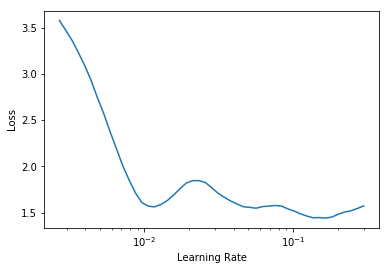

In [36]:
learner.plot_lrs(10)

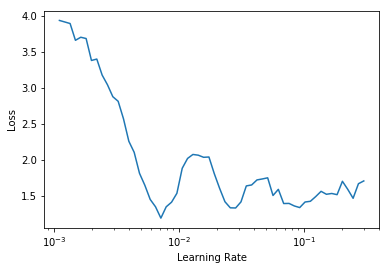

In [37]:
learner.plot_lrs(1)

In [38]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [39]:
learner.run_epochs(dltrain,None,5)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.5087578296661377  Valid Loss:1.5122517347335815 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.1265578269958496  Valid Loss:1.1264547109603882 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.1069629192352295  Valid Loss:1.1083130836486816 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0667152404785156  Valid Loss:1.067103385925293 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0195060968399048  Valid Loss:1.021988868713379 


In [40]:
learner.run_epochs(dltrain,None,5)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.00487220287323  Valid Loss:1.0115420818328857 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9925909042358398  Valid Loss:0.9986651539802551 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9873912334442139  Valid Loss:1.001807451248169 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9831650257110596  Valid Loss:0.9873334765434265 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9845789670944214  Valid Loss:1.0001295804977417 


In [41]:
learner.run_epochs(dltrain,None,5)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9809685349464417  Valid Loss:0.993939995765686 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.972716748714447  Valid Loss:0.9862625002861023 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9699752926826477  Valid Loss:0.9862390160560608 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9693990349769592  Valid Loss:0.9806976318359375 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9661526083946228  Valid Loss:0.9821053147315979 


In [42]:
learner.run_epochs(dltrain,None,5)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9653265476226807  Valid Loss:0.9748008251190186 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9607943892478943  Valid Loss:0.9753757119178772 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9582374095916748  Valid Loss:0.9695466160774231 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9562011957168579  Valid Loss:0.9720402359962463 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9562660455703735  Valid Loss:0.9759615063667297 


In [43]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=5e-4)

In [45]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9558642506599426  Valid Loss:0.9794108867645264 
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:0.9419751763343811  Valid Loss:0.9618624448776245 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.9292581677436829  Valid Loss:0.9596880078315735 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9485921263694763  Valid Loss:0.965660572052002 
Epoch:4 Learning rate 0.0028117066259517455 Weight Decay 1e-07 Train Loss:0.9422135353088379  Valid Loss:0.965596616268158 
Epoch:5 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:0.9347347617149353  Valid Loss:0.9589194059371948 
Epoch:6 Learning rate 0.0008891397050194614 Weight Decay 1e-07 Train Loss:0.9273792505264282  Valid Loss:0.954558253288269 
Epoch:7 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.918846607208252  Valid Loss:0.9529931545257568 
Epoch:8 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.945028

In [64]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=5e-4)

In [65]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9335755109786987  Valid Loss:0.9607924818992615 
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:0.9230169653892517  Valid Loss:0.9534813165664673 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.9126103520393372  Valid Loss:0.9518972039222717 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9334462285041809  Valid Loss:0.9647504091262817 
Epoch:4 Learning rate 0.0028117066259517455 Weight Decay 1e-07 Train Loss:0.9265683889389038  Valid Loss:0.9592859148979187 
Epoch:5 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:0.9155821800231934  Valid Loss:0.953285276889801 
Epoch:6 Learning rate 0.0008891397050194614 Weight Decay 1e-07 Train Loss:0.9081218838691711  Valid Loss:0.947343111038208 
Epoch:7 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.9028286933898926  Valid Loss:0.9479477405548096 
Epoch:8 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9269

In [66]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=5e-4)

In [67]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9227352738380432  Valid Loss:0.9593266248703003 
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:0.9093417525291443  Valid Loss:0.949210524559021 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.8993503451347351  Valid Loss:0.9448545575141907 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9211909770965576  Valid Loss:0.9562923908233643 
Epoch:4 Learning rate 0.0028117066259517455 Weight Decay 1e-07 Train Loss:0.9166509509086609  Valid Loss:0.9566781520843506 
Epoch:5 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:0.9057846665382385  Valid Loss:0.9518290758132935 
Epoch:6 Learning rate 0.0008891397050194614 Weight Decay 1e-07 Train Loss:0.8965703845024109  Valid Loss:0.9416940212249756 
Epoch:7 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.8913222551345825  Valid Loss:0.9458622336387634 
Epoch:8 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.913

In [68]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [70]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((100, 6041), (25, 100))

In [71]:
df_train.shape

(3707, 6041)

In [72]:
from scipy.special import expit

df_train_item_autoenc=np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)
df_valid_item_autoenc=np.tanh(expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T)

In [73]:
df_train_item_autoenc=expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T
df_valid_item_autoenc=expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T

In [74]:
df_train_item_autoenc.shape

(3707, 25)

In [75]:
df_valid_item_autoenc.shape

(3707, 25)

In [76]:
df_train_item_autoenc=pd.DataFrame(df_train_item_autoenc)
df_valid_item_autoenc=pd.DataFrame(df_valid_item_autoenc)

In [77]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([100, 6041])

In [78]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([25, 100])

In [79]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [80]:
df_train_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_train_item_autoenc.shape[1])]

In [81]:
df_valid_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_valid_item_autoenc.shape[1])]

In [82]:
df_train_item_autoenc.reset_index(inplace=True)

In [83]:
df_valid_item_autoenc.reset_index(inplace=True)

In [84]:
df_train_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)
df_valid_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)

In [85]:
import pickle
pickle.dump([df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))